# Elastic weight consolidation
* [논문 링크](https://arxiv.org/abs/1612.00796)에서 제안한 ECW 구현 방법을 알아보자.
* old task A 로 학습 된 모델이 있다고 하자.
* 모델은 아래 그림의 회색 부분 처럼 task A에 최적화 되어 학습 되어 있을 것이다.
* 그런데 이 모델을 가져다 새로운 task B에 최적화 하도록 학습한다면?
  * 그냥 학습시키면 아래 파란 화살표처럼 task B에 최적화 되도록 학습되어 이전에 풀 수 있던 task A는 까먹게 된다.
  * 요걸 방지하기 위해서 두 task A와 B 모두 풀 수 있도록 하겠다는 것이다(아래 빨강 화살표).

![fig1](./imgs/Overcoming_catastrophic_forgetting_in_neural_networks_fig1.png)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd

In [2]:
BATCH_SIZE = 2**9
EPOCHS = 5
print('BATCH_SIZE', BATCH_SIZE)
print('EPOCHS', EPOCHS)

BATCH_SIZE 512
EPOCHS 5


## 데이터 준비
* 대부분의 continual learning 연구는 task 별로 픽셀을 랜덤하게 섞어서 내놓는 mnist permutation을 한다.
* 이 예제에서는 task 별로 클래스를 나누어서 만들어보자.

In [3]:
def get_task(X, y, digits=[5,6,7,7,9]):
    '''
    inputs:
        X, y
        digits = new task
    return:
        old task에 대한 X, y
        new task에 대한 X, y
    '''
    idx = np.arange(len(X))
    no_idx = list()
    for d in digits:
        no_idx.extend(np.where(y==d))
    no_idx = np.concatenate(no_idx, axis=0)
    idx = np.delete(idx, no_idx)
    return np.expand_dims(X[idx], axis=-1).astype(np.float32), np.expand_dims(y[idx], axis=-1).astype(np.float32), np.expand_dims(X[no_idx], axis=-1).astype(np.float32), np.expand_dims(y[no_idx], axis=-1).astype(np.float32)

In [4]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.
X_test = X_test / 255.

XA_train, yA_train, XB_train, yB_train = get_task(X_train, y_train)
XA_test, yA_test, XB_test, yB_test = get_task(X_test, y_test)

In [5]:
train_A = tf.data.Dataset.from_tensor_slices((XA_train, yA_train)).shuffle(len(XA_train)).batch(BATCH_SIZE)
train_B = tf.data.Dataset.from_tensor_slices((XB_train, yB_train)).shuffle(len(XB_train)).batch(BATCH_SIZE)

test_A = tf.data.Dataset.from_tensor_slices((XA_test, yA_test)).batch(BATCH_SIZE)
test_B = tf.data.Dataset.from_tensor_slices((XB_test, yB_test)).batch(BATCH_SIZE)

### Task A 데이터 그려보기

In [6]:
def plot_tasksamples(X, y, size=5):
    print(np.unique(y))
    idx = np.random.randint(len(X), size=size)
    fig, ax = plt.subplots(nrows=1,ncols=size)
    for i in range(size):
        ax[i].imshow(X[i])
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

[0. 1. 2. 3. 4. 8.]


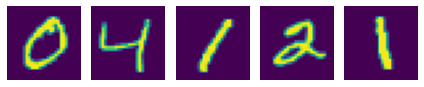

In [7]:
plot_tasksamples(XA_train, yA_train)

### Task B 데이터 그려보기

[5. 6. 7. 9.]


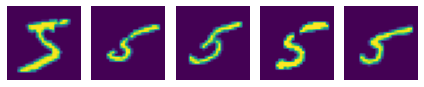

In [8]:
plot_tasksamples(XB_train, yB_train)

## 유틸

In [9]:
def test(model, A, B):
    def _test(model, D):
    
        acc_total = metrics.Mean()

        acc = metrics.Mean()
        ace = metrics.SparseCategoricalAccuracy()

        for inputs in D:
            x, y = inputs
            y_pred = model(x)
            _acc = ace(y, y_pred).numpy()
            acc.update_state(_acc)
            acc_total.update_state(_acc)
        return acc
    
    accA = _test(model, A)
    accB = _test(model, B)
    print(f"Task A: {accA.result().numpy()*100:.2f}%")
    print(f"Task B: {accB.result().numpy()*100:.2f}%")

## 간단 모델

In [10]:
class Model(models.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.Sequential([
            layers.Dense(128, activation=tf.nn.tanh),
            layers.Dense(128, activation=tf.nn.tanh),
            layers.Dense(10, activation=tf.nn.softmax),
        ])
        
    def call(self, inputs, training=False):
        x = layers.Flatten()(inputs)
        x = self.model(x, training=training)
        return x
    
model = Model()
model.build((None,28,28,1))

## Task A 학습

In [11]:
opt = optimizers.Adam(learning_rate=1e-4)
cce = losses.SparseCategoricalCrossentropy()

loss = metrics.Mean()
acc = metrics.Mean()
ace = metrics.SparseCategoricalAccuracy()

for e in range(EPOCHS):
    start_time = time.time()
    ace.reset_states()
    
    for inputs in train_A:
        x, y = inputs
        with tf.GradientTape() as t:
            y_pred = model(x)
            _loss = cce(y, y_pred)
            
        grads = t.gradient(_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        loss.update_state(_loss)
        acc.update_state(ace(y, y_pred))
        
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, loss={loss.result():.8f}, acc={acc.result()*100:.2f}%, {time.time()-start_time:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()
    test(model, test_A, test_B)

5/5, loss=0.25337666, acc=93.32%, 0.77 sec/epoch
Task A: 94.06%
Task B: 0.00%


In [12]:
model.save_weights('./weights/model_A')

## Task 별 정확도 체크 (task A에 대한 학습)

In [13]:
test(model, test_A, test_B)

Task A: 94.06%
Task B: 0.00%


## Task B 를 위한 그냥 학습
* 위에서 학습 해둔 모델 (task A를 위한) 을 그냥 학습

In [14]:
model.load_weights('./weights/model_A')

In [15]:
opt = optimizers.Adam(learning_rate=1e-4)
cce = losses.SparseCategoricalCrossentropy()

loss = metrics.Mean()
acc = metrics.Mean()
ace = metrics.SparseCategoricalAccuracy()

for e in range(EPOCHS):
    start_time = time.time()
    ace.reset_states()
    
    for inputs in train_B:
        x, y = inputs
        with tf.GradientTape() as t:
            y_pred = model(x)
            _loss = cce(y, y_pred)
            
        grads = t.gradient(_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        loss.update_state(_loss)
        acc.update_state(ace(y, y_pred))
        
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, loss={loss.result():.8f}, acc={acc.result()*100:.2f}%, {time.time()-start_time:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()
    test(model, test_A, test_B)

5/5, loss=0.26446968, acc=93.37%, 0.63 sec/epoch
Task A: 14.87%
Task B: 93.59%


In [16]:
model.save_weights('./weights/model_A_to_B')

## Task 별 정확도 체크 (task B에 대한 학습)

In [17]:
test(model, test_A, test_B)

Task A: 14.87%
Task B: 93.59%


* Task A 를 어떻게 푸는지 까먹음 (catastrophic forgetting)

## ECW
* Task A 를 위해 학습해둔 모델을 다시 가져다가 ECW 를 구현해보자.

* ECW 에서 제안한 로스는 아래와 같다.

$$
L(\theta) = L_B(\theta) + \sum_i {\lambda \over 2} F_i (\theta_i - \theta^*_{A,i})^2
$$

이 때,
* $L_B (\theta)$: 문제 B에 관한 로스. 여기서는 categorical cross entropy에 해당
* $i$: 모델 파라미터 $\theta$ 의 인덱스 번호
* $\lambda$: task A와 task B 중에 뭐가 더 중요한지 나누는 가중치 파라미터
* $F$: 는 Fisher information matrix 를 뜻한다.


Fisher information matrix 는 log likelihood 을 두 번 편미분한 Hessian 의 negative expectation 과 같다. [링크](https://en.wikipedia.org/wiki/Fisher_information) 따라서, F 는 아래와 같이 구현하면 된다.

In [21]:
# task A 를 위한 모델
model_A = Model()
model_A.build((None,28,28,1))
model_A.load_weights('./weights/model_A')

# task A 푸는 능력 보존하면서 task B 푸는 거 배울 모델
model.load_weights('./weights/model_A')

opt = optimizers.Adam(learning_rate=1e-4)
cce = losses.SparseCategoricalCrossentropy()

loss = metrics.Mean()
acc = metrics.Mean()
ace = metrics.SparseCategoricalAccuracy()

LAMBDA = 1e1 * 2.5

for e in range(EPOCHS):
    start_time = time.time()
    ace.reset_states()
    
    for inputs in train_B:
        x, y = inputs
        with tf.GradientTape(persistent=True) as t:
            with tf.GradientTape() as f:
                y_pred = model(x)
                _loss_b = cce(y, y_pred) # Loss_B
            F = f.gradient(_loss_b, model.trainable_variables)
            F = t.gradient(F, model.trainable_variables)

            # 여기가 로스의 F에 관한거
            l2 = .0
            for i in range(6): # 레이어 개수
                l2 += tf.reduce_sum(
                    tf.multiply(
                        F[i], 
                        (model.get_weights()[i] - model_A.get_weights()[i])**2
                    )
                )
                
            l2 = tf.abs(l2)
                
            # 통합
            _loss = _loss_b + LAMBDA * l2
            
        grads = t.gradient(_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        loss.update_state(_loss)
        acc.update_state(ace(y, y_pred))
        
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, loss={loss.result():.8f}, acc={acc.result()*100:.2f}%, {time.time()-start_time:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()
    
    test(model, test_A, test_B)

5/5, loss=1.57280147, acc=57.49%, 2.46 sec/epoch
Task A: 61.00%
Task B: 59.29%


* overall 은 더 나아졌지만, epochs, batch size 나 $\lambda$와  같은 하이퍼파라미터에 매우 민감함